## Data Cleaning

##### Import necessary modules

In [47]:
from pyspark.sql import SparkSession
from utils.Constants import Constants
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Configure the hadoop dir path

In [2]:
BASE_PATH = 'hdfs://localhost:9000/user/hadoop'
INPUT_PATH = f'{BASE_PATH}/inputs'
MERGED_PATH = f'{BASE_PATH}/merged'
CLEANED_PATH = f'{BASE_PATH}/cleaned'

print('input path {} , merge path {}'.format(INPUT_PATH, MERGED_PATH))

input path hdfs://localhost:9000/user/hadoop/inputs , merge path hdfs://localhost:9000/user/hadoop/merged


##### Read the data that we have merged

In [28]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read CSV from HDFS") \
    .getOrCreate()

# Path to the CSV file on HDFS
file_path = f'{MERGED_PATH}/combined_raw_data.csv'

# Read the CSV file into a DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=False)

df.printSchema()
df.show(5)


root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)

+----+--------+--------+------+---+---+-----+----+---+---+----+-----+
| _c0|     _c1|     _c2|   _c3|_c4|_c5|  _c6| _c7|_c8|_c9|_c10| _c11|
+----+--------+--------+------+---+---+-----+----+---+---+----+-----+
|3601|21/05/13|12:00:00| 0.278|233|  0|34.92|60.8|0.3|1.7| 125|26.24|
|3602|21/05/13|12:05:00|0.2776|751|  0|34.26|60.9|0.3|1.3| 124|25.65|
|3603|21/05/13|12:10:00|0.2776|963|  0|35.18|59.6|0.3|1.3| 114|26.15|
|3604|21/05/13|12:15:00|0.2776|956|  0| 35.8|57.5|0.3|1.3| 107|26.12|
|3605|21/05/13|12:20:00|0.2776|994|  0|35.98|58.8|0.3|1.3| 105|26.68|
+----+------

##### Let change the col. name for readable

In [29]:
from pyspark.sql import SparkSession

# Assuming 'df' is your DataFrame
# Rename columns
column_mapping = {
    "_c1": "date",
    "_c2": "time",
    "_c3": "water_content(m3/m3)",
    "_c4": "solar_radiation(w/m2)",
    "_c5": "rain(mm)",
    "_c6": "temperature(celcius)",
    "_c7": "rh(%)",
    "_c8": "wind_speed(m/s)",
    "_c9": "gust_speed(m/s)",
    "_c10": "wind_direction(degree)",
    "_c11": "dew_point(celcius)"
}

# Start with the original DataFrame
rename_cf = df

# Rename columns iteratively
for old_name, new_name in column_mapping.items():
    rename_cf = rename_cf.withColumnRenamed(old_name, new_name)

# Show the DataFrame schema after renaming
print("col. before rename : ")
df.printSchema()
print("col. after rename : ")
rename_cf.printSchema()



col. before rename : 
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)

col. after rename : 
root
 |-- _c0: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content(m3/m3): string (nullable = true)
 |-- solar_radiation(w/m2): string (nullable = true)
 |-- rain(mm): string (nullable = true)
 |-- temperature(celcius): string (nullable = true)
 |-- rh(%): string (nullable = true)
 |-- wind_speed(m/s): string (nullable = true)
 |-- gust_speed(m/s): string (nullable = true)
 |-- wind_direction(degree): string (nullable = true)
 |-- dew_point(celcius): string (nu

##### Change the format date from yy/MM/dd to dd-MM-yyyy

In [30]:
from pyspark.sql import functions as F

# Reformatting the date and time columns
df_transformed = rename_cf.withColumn("date", F.date_format(F.to_date("date", "yy/MM/dd"), "dd-MM-yyyy"))

df_transformed.show(5, truncate=False)


+----+----------+--------+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+
|_c0 |date      |time    |water_content(m3/m3)|solar_radiation(w/m2)|rain(mm)|temperature(celcius)|rh(%)|wind_speed(m/s)|gust_speed(m/s)|wind_direction(degree)|dew_point(celcius)|
+----+----------+--------+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+
|3601|13-05-2021|12:00:00|0.278               |233                  |0       |34.92               |60.8 |0.3            |1.7            |125                   |26.24             |
|3602|13-05-2021|12:05:00|0.2776              |751                  |0       |34.26               |60.9 |0.3            |1.3            |124                   |25.65             |
|3603|13-05-2021|12:10:00|0.2776              |963                  |0       |35.18               |5

##### Drop a _c0 col.

In [35]:
# Drop the "_cO" column
drop_c0_colunm = df_transformed.drop('_c0')
drop_c0_colunm.printSchema()


root
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content(m3/m3): float (nullable = true)
 |-- solar_radiation(w/m2): float (nullable = true)
 |-- rain(mm): float (nullable = true)
 |-- temperature(celcius): float (nullable = true)
 |-- rh(%): float (nullable = true)
 |-- wind_speed(m/s): float (nullable = true)
 |-- gust_speed(m/s): float (nullable = true)
 |-- wind_direction(degree): float (nullable = true)
 |-- dew_point(celcius): float (nullable = true)



##### Change the datatype of each col.

In [38]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, DateType, StringType

# List of columns with their desired data types
columns_to_cast = {
    "date": DateType(),
    "time": StringType(),
    "water_content(m3/m3)": FloatType(),
    "solar_radiation(w/m2)": FloatType(),
    "rain(mm)": FloatType(),
    "temperature(celcius)": FloatType(),
    "rh(%)": FloatType(),
    "wind_speed(m/s)": FloatType(),
    "gust_speed(m/s)": FloatType(),
    "wind_direction(degree)": FloatType(),
    "dew_point(celcius)": FloatType()
}

# Apply casting to each column
for column, data_type in columns_to_cast.items():
    drop_c0_colunm = drop_c0_colunm.withColumn(column, F.col(column).cast(data_type))

# Schema after casting
drop_c0_colunm.printSchema()


root
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content(m3/m3): float (nullable = true)
 |-- solar_radiation(w/m2): float (nullable = true)
 |-- rain(mm): float (nullable = true)
 |-- temperature(celcius): float (nullable = true)
 |-- rh(%): float (nullable = true)
 |-- wind_speed(m/s): float (nullable = true)
 |-- gust_speed(m/s): float (nullable = true)
 |-- wind_direction(degree): float (nullable = true)
 |-- dew_point(celcius): float (nullable = true)



In [ ]:
def find_outliers_IQR(spark_df, column):
        # Calculate Q1 and Q3
        q1, q3 = spark_df.approxQuantile(column, [0.25, 0.75], 0.0)
        IQR = q3 - q1

        # Define outlier bounds
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR

        # Filter outliers
        outliers = spark_df.filter((F.col(column) < lower_bound) | (F.col(column) > upper_bound))
        return outliers

##### Check an outlier of each col. in dataset

In [53]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType


# Identify numeric columns
numeric_columns = [field.name for field in drop_c0_colunm.schema.fields if isinstance(field.dataType, NumericType)]

# Iterate over numeric columns and check for outliers
for column in numeric_columns:
    outliers = find_outliers_IQR(drop_c0_colunm, column)
    num_outliers = outliers.count()
    
    if num_outliers > 0:
        max_outlier = outliers.agg(F.max(column).alias('max_outlier')).collect()[0]['max_outlier']
        min_outlier = outliers.agg(F.min(column).alias('min_outlier')).collect()[0]['min_outlier']
        print(f"Column: {column}")
        print(f"  Number of outliers: {num_outliers}")
        print(f"  Max outlier value: {max_outlier}")
        print(f"  Min outlier value: {min_outlier}")
        print("-" * 40)
    else:
        print(f"Column: {column}")
        print("  No outliers found.")
        print("-" * 40)


Column: water_content(m3/m3)
  Number of outliers: 4902
  Max outlier value: 0.39149999618530273
  Min outlier value: -99850510336.0
----------------------------------------
Column: solar_radiation(w/m2)
  Number of outliers: 6468
  Max outlier value: 41269.0
  Min outlier value: 819.0
----------------------------------------
Column: rain(mm)
  Number of outliers: 3177
  Max outlier value: 6555.2001953125
  Min outlier value: 0.20000000298023224
----------------------------------------
Column: temperature(celcius)
  Number of outliers: 612
  Max outlier value: 537.3300170898438
  Min outlier value: -888.8800048828125
----------------------------------------
Column: rh(%)
  Number of outliers: 437
  Max outlier value: 3361.5
  Min outlier value: 0.0
----------------------------------------
Column: wind_speed(m/s)
  Number of outliers: 27027
  Max outlier value: 43.099998474121094
  Min outlier value: 1.0
----------------------------------------
Column: gust_speed(m/s)
  Number of outlie

##### Show the outlier as boxplot

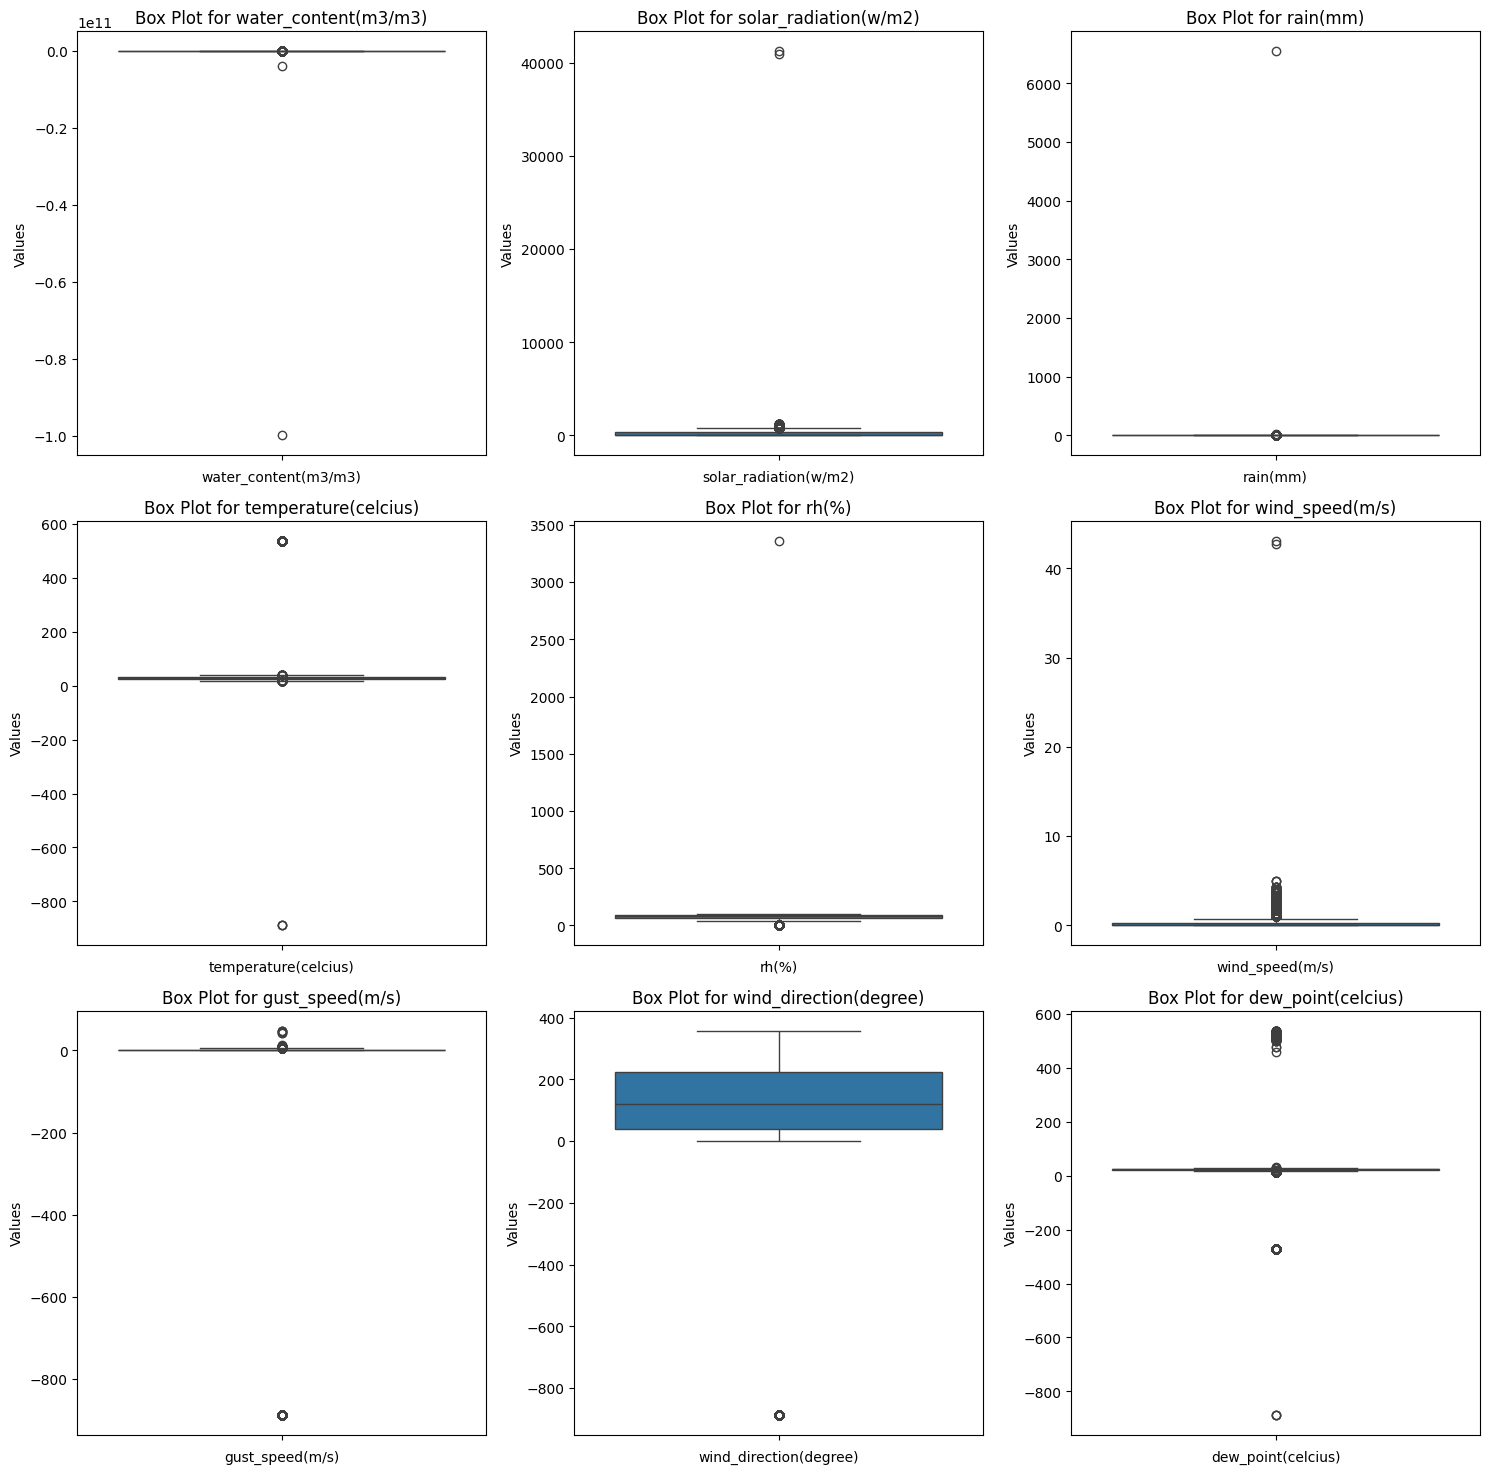

In [ ]:
numeric_data = drop_c0_colunm.select(numeric_columns).toPandas()

ncols = 3 
nrows = int(np.ceil(len(numeric_columns) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=numeric_data[column], ax=axes[i])
    axes[i].set_ylabel("Values")
    axes[i].set_xlabel(column)

for i in range(len(numeric_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


##### Drop the dulpicate value from dataframe

In [7]:
# Drop duplicates from the DataFrame
df_no_duplicates = df_transformed.dropDuplicates()

# Find the duplicate rows by subtracting deduplicated data from the original
duplicates = df_transformed.subtract(df_no_duplicates)

# Show the duplicated rows
duplicates.show(5)


+---+----+----+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+
|_c0|date|time|water_content(m3/m3)|solar_radiation(w/m2)|rain(mm)|temperature(celcius)|rh(%)|wind_speed(m/s)|gust_speed(m/s)|wind_direction(degree)|dew_point(celcius)|
+---+----+----+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+
+---+----+----+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+



##### Drop _c0 Column 

In [8]:
# Drop the "_cO" column
drop_c0_colunm = df_no_duplicates.drop('_c0')

In [9]:
print("col. after drop _c0")
drop_c0_colunm.printSchema()

col. after drop _c0
root
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content(m3/m3): string (nullable = true)
 |-- solar_radiation(w/m2): string (nullable = true)
 |-- rain(mm): string (nullable = true)
 |-- temperature(celcius): string (nullable = true)
 |-- rh(%): string (nullable = true)
 |-- wind_speed(m/s): string (nullable = true)
 |-- gust_speed(m/s): string (nullable = true)
 |-- wind_direction(degree): string (nullable = true)
 |-- dew_point(celcius): string (nullable = true)



##### Write it into hadoop

In [12]:
drop_c0_colunm.write \
    .mode("overwrite") \
    .option("header", "true") \
    .option("compression", "none") \
    .csv(f'{CLEANED_PATH}/cleaned_data.csv')

##### Verify the file write successfully

In [15]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read CSV from HDFS") \
    .getOrCreate()

# Path to the CSV file on HDFS
file_path = f'{CLEANED_PATH}/cleaned_data.csv'

schema = Constants.WEATHER_DATA_SCHEMA
# Read the CSV file into a DataFrame
df = spark.read.csv(file_path, header=True)

df.show(5)
df.printSchema()
df.count()


+----------+--------+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+
|      date|    time|water_content(m3/m3)|solar_radiation(w/m2)|rain(mm)|temperature(celcius)|rh(%)|wind_speed(m/s)|gust_speed(m/s)|wind_direction(degree)|dew_point(celcius)|
+----------+--------+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+
|13-05-2021|14:35:00|              0.2773|                  671|       0|               36.52| 57.5|            0.7|            2.3|               -888.88|              26.8|
|14-05-2021|04:20:00|              0.2756|                    1|       0|               27.09| 93.1|              0|              0|               -888.88|             25.91|
|14-05-2021|15:00:00|              0.2756|                  581|       0|               34.97| 63.9|            0.7|         

160436